In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

<h3> Load Dataset </h3>

The Federal Reserve Economic Database (FRED) provides historical daily exchange rates of all major currencies in the world.

In [2]:
df = pd.read_csv('datasets/fred_fxrates.csv')
mask = (df['Date'] >= '1999-01-04') & (df['Date'] <= '2013-09-20')
df = df.loc[mask]
df = df.set_index('Date')
fxrates = df[["DEXCHUS", "DEXJPUS", "DEXKOUS", "DEXMAUS", "DEXUSEU", "DEXUSUK", "DEXTHUS", "DEXSZUS"]]

In [3]:
fxrates.head() 

,DEXCHUS,DEXJPUS,DEXKOUS,DEXMAUS,DEXUSEU,DEXUSUK,DEXTHUS,DEXSZUS
Date,,,,,,,,
1999-01-04,8.2793,112.15,1187.5,3.8,1.1812,1.6581,36.20,1.3666
1999-01-05,8.2795,111.15,1166.0,3.8,1.1760,1.6566,36.18,1.3694
1999-01-06,8.2795,112.78,1160.0,3.8,1.1636,1.6547,36.50,1.3852
1999-01-07,8.2798,111.69,1151.0,3.8,1.1672,1.6495,36.30,1.3863
1999-01-08,8.2796,111.52,1174.0,3.8,1.1554,1.6405,36.45,1.3970


In [4]:
fxrates.tail() 

,DEXCHUS,DEXJPUS,DEXKOUS,DEXMAUS,DEXUSEU,DEXUSUK,DEXTHUS,DEXSZUS
Date,,,,,,,,
2013-09-16,6.1198,98.98,1081.34,3.2880,1.3350,1.5927,31.66,0.9258
2013-09-17,6.1213,99.16,1082.15,3.2455,1.3357,1.5901,31.68,0.9266
2013-09-18,6.1210,99.04,1081.40,3.2320,1.3351,1.5965,31.65,0.9260
2013-09-19,6.1210,99.33,1070.88,3.1455,1.3527,1.6043,31.03,0.9112
2013-09-20,6.1210,99.38,1076.02,3.1640,1.3522,1.6021,31.04,0.9104


<h3> Symbols & Its Units Details </h3>

In [5]:
symbols = ["DEXCHUS", "DEXJPUS", "DEXKOUS", "DEXMAUS", "DEXUSEU", "DEXUSUK", "DEXTHUS", "DEXSZUS"]
fxUnits = ["Chinese Yuan to 1 U.S. $", "Japanese Yen to 1 U.S. $", "South Korean Won to 1 U.S. $", 
           "Malaysian Ringgit to 1 U.S. $", "U.S. $ to 1 Euro", "U.S. $ to 1 British Pound", 
           "Thai Baht to 1 U.S. $", "Swiss Francs to 1 U.S. $"] 
df = pd.DataFrame(columns=["Symbols","fxUnits"])
df["Symbols"] = symbols
df["fxUnits"] = fxUnits
display(df)

,Symbols,fxUnits
0,DEXCHUS,Chinese Yuan to 1 U.S. $
1,DEXJPUS,Japanese Yen to 1 U.S. $
2,DEXKOUS,South Korean Won to 1 U.S. $
3,DEXMAUS,Malaysian Ringgit to 1 U.S. $
4,DEXUSEU,U.S. $ to 1 Euro
5,DEXUSUK,U.S. $ to 1 British Pound
6,DEXTHUS,Thai Baht to 1 U.S. $
7,DEXSZUS,Swiss Francs to 1 U.S. $


<h3> Plot Exchange Rates Time Series </h3>

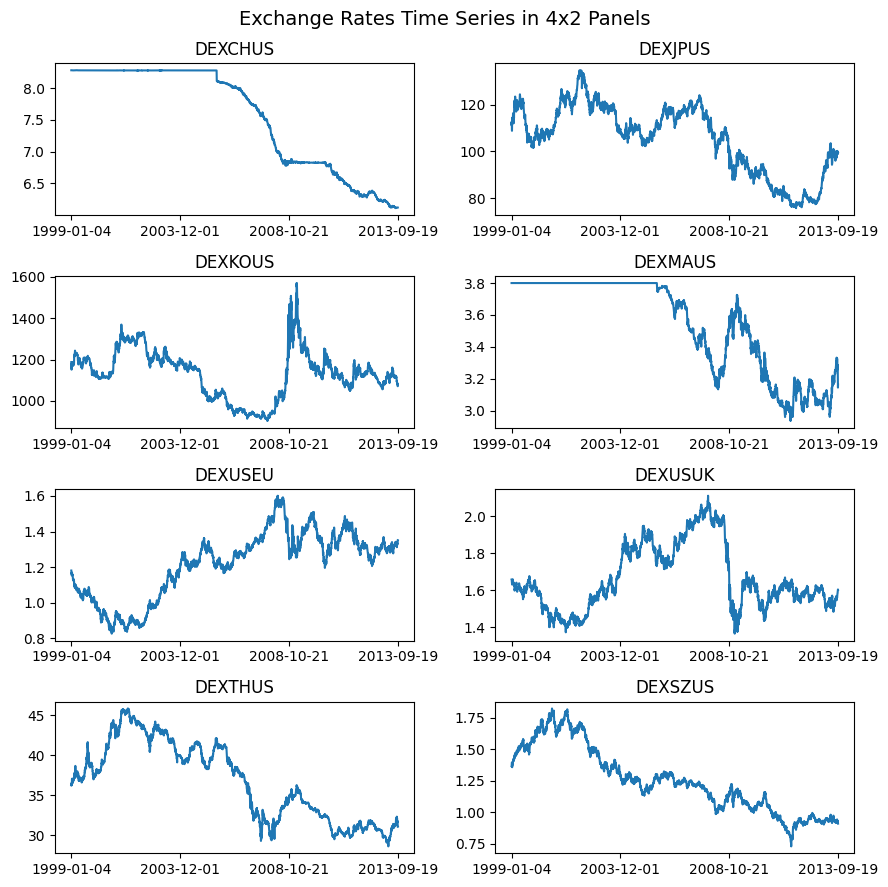

In [6]:
# Set the layout for 4x2 subplots
fig, axs = plt.subplots(4, 2, figsize=(9,9))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Select three dates for x-axis labels
selected_dates = fxrates.index[::(len(fxrates.index) // 3)]

# Loop through each column of the DataFrame and plot in the corresponding subplot
for j0, ax in zip(range(1, fxrates.shape[1] + 1), axs):
    column_name = fxrates.columns[j0 - 1]
    ax.plot(range(len(fxrates)),fxrates.iloc[:, j0 - 1])
    ax.set_xticks(range(0, len(fxrates), len(fxrates) // 3))
    ax.set_xticklabels(selected_dates)
    ax.set_title(column_name)

# Set the main title for the entire plot
plt.suptitle("Exchange Rates Time Series in 4x2 Panels", fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

<h3> Exchange Rate Regimes Model </h3>

The Chinese Yuan was pegged to the US Dollar prior to July 2005. Then, China
announced that the exchange rate would be set with reference to a basket of
other currencies, allowing for a movement of up to 0.3% movement within any
given day. **The actual currencies and their basket weights are unannounced by
China.**

From an empirical standpoint, there are several important questions:</br>
• For any given period, what is the implicit reference basket for the Chinese
currency?</br>
• Has the reference basket changed over time?</br>
• Has the Chinese currency depreciated with respect to the dollar?
If so, how much and when?</br>

Frankel and Wei (1994) detail methodology for evaluating the implicit exchange rate regime of a currency. The approach regesses changes in the target currency on changes in the values of possible currencies in the reference basket.

To apply this methodology we re-express the dollar-based exchange rates using another currency, the Swiss Franc. This allows currency moves of the dollar to be be used to explain moves in the Yuan. The choice of Swiss Franc is
consistent with evaluations with respect to a stable, developed-market currency.

<h3> Converting from USD Base to Swiss Franc Base </h3>

In [7]:
# Create a copy of the DataFrame 'fxrates' to store the converted rates
fxrates1 = fxrates.copy()

# Convert currencies to the base rate of DEXSZUS (Swiss Franc)
# For exchange rates with 1 U.S. $ in base, divide by DEXSZUS
cols_to_divide_by_dexszus = ['DEXCHUS', 'DEXJPUS', 'DEXKOUS', 'DEXMAUS', 'DEXTHUS']
fxrates1[cols_to_divide_by_dexszus] = fxrates1[cols_to_divide_by_dexszus].div(fxrates['DEXSZUS'], axis=0)

# For exchange rates with 1 U.S. $ in numerator, divide inverse by DEXSZUS
cols_to_divide_inverse_by_dexszus = ['DEXUSEU', 'DEXUSUK']
fxrates1[cols_to_divide_inverse_by_dexszus] = (1. / fxrates1[cols_to_divide_inverse_by_dexszus]).div(fxrates['DEXSZUS'], axis=0)

# For USD, divide $1 by the DEXSZUS rate
fxrates1['DEXSZUS'] = 1 / fxrates['DEXSZUS']

# Rename series in terms of the SWIFT currency codes
list_symbol_swiftcode = ["CNY", "YEN", "WON", "MYR", "EUR", "GBP", "THB", "USD"]
fxrates1.columns = [f"{symbol}_SFR" for symbol in list_symbol_swiftcode]

# Display the updated DataFrame 'fxrates1'
print(fxrates1.head())

             CNY_SFR    YEN_SFR     WON_SFR   MYR_SFR   EUR_SFR   GBP_SFR  \
Date                                                                        
1999-01-04  6.058320  82.064979  868.944827  2.780623  0.619491  0.441314   
1999-01-05  6.046079  81.166934  851.467796  2.774938  0.620958  0.440811   
1999-01-06  5.977115  81.417846  837.424199  2.743286  0.620417  0.436283   
1999-01-07  5.972589  80.566977  830.267619  2.741109  0.618013  0.437311   
1999-01-08  5.926700  79.828203  840.372226  2.720115  0.619543  0.436342   

              THB_SFR   USD_SFR  
Date                             
1999-01-04  26.489097  0.731743  
1999-01-05  26.420330  0.730247  
1999-01-06  26.349986  0.721917  
1999-01-07  26.184808  0.721345  
1999-01-08  26.091625  0.715820  


<h3> Plot Swiss Franc Base Exchange Rates Time Series </h3>

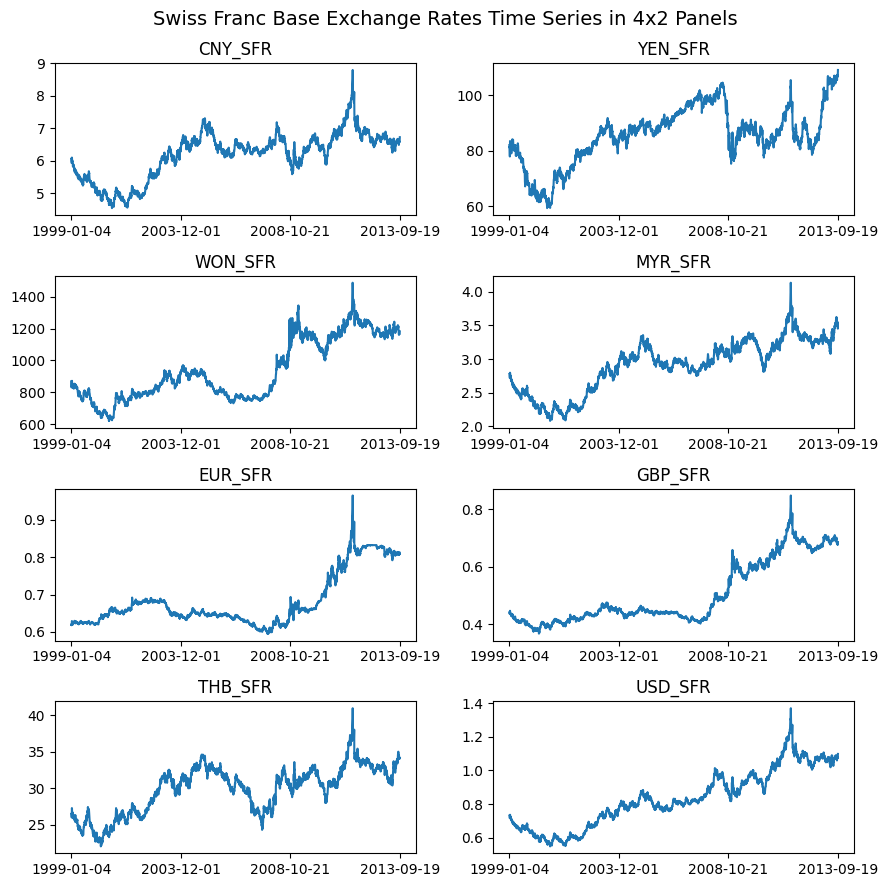

In [8]:
# Set the layout for 4x2 subplots
fig, axs = plt.subplots(4, 2, figsize=(9,9))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Select three dates for x-axis labels
selected_dates = fxrates1.index[::(len(fxrates1.index) // 3)]

# Loop through each column of the DataFrame and plot in the corresponding subplot
for j0, ax in zip(range(1, fxrates1.shape[1] + 1), axs):
    column_name = fxrates1.columns[j0 - 1]
    ax.plot(range(len(fxrates1)),fxrates1.iloc[:, j0 - 1])
    ax.set_xticks(range(0, len(fxrates1), len(fxrates1) // 3))
    ax.set_xticklabels(selected_dates)
    ax.set_title(column_name)

    
# Set the main title for the entire plot
plt.suptitle("Swiss Franc Base Exchange Rates Time Series in 4x2 Panels", fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

<h3> Convert Data to Log Returns </h3>

In [9]:
# Compute daily price changes on the log scale
fxrates1_logret = pd.DataFrame()
for column in fxrates1.columns:
    fxrates1_logret[column] = fxrates1[column].apply(lambda x: None if x == 0 else x).dropna().pct_change()
fxrates1_logret = fxrates1_logret.dropna()

# Display the dimensions of the resulting DataFrame
print(f"Dimensions of fxrates1_logret: {fxrates1_logret.shape}")

# Display the column names of fxrates1_logret
print(fxrates1_logret.head())

Dimensions of fxrates1_logret: (3703, 8)
             CNY_SFR   YEN_SFR   WON_SFR   MYR_SFR   EUR_SFR   GBP_SFR  \
Date                                                                     
1999-01-05 -0.002021 -0.010943 -0.020113 -0.002045  0.002368 -0.001141   
1999-01-06 -0.011406  0.003091 -0.016493 -0.011406 -0.000871 -0.010271   
1999-01-07 -0.000757 -0.010451 -0.008546 -0.000793 -0.003875  0.002356   
1999-01-08 -0.007683 -0.009170  0.012170 -0.007659  0.002475 -0.002215   
1999-01-11  0.000513 -0.023632  0.001354  0.000501  0.002236  0.002334   

             THB_SFR   USD_SFR  
Date                            
1999-01-05 -0.002596 -0.002045  
1999-01-06 -0.002663 -0.011406  
1999-01-07 -0.006269 -0.000793  
1999-01-08 -0.003559 -0.007659  
1999-01-11 -0.004165  0.000501  


<h3> Plot Log Returns </h3>

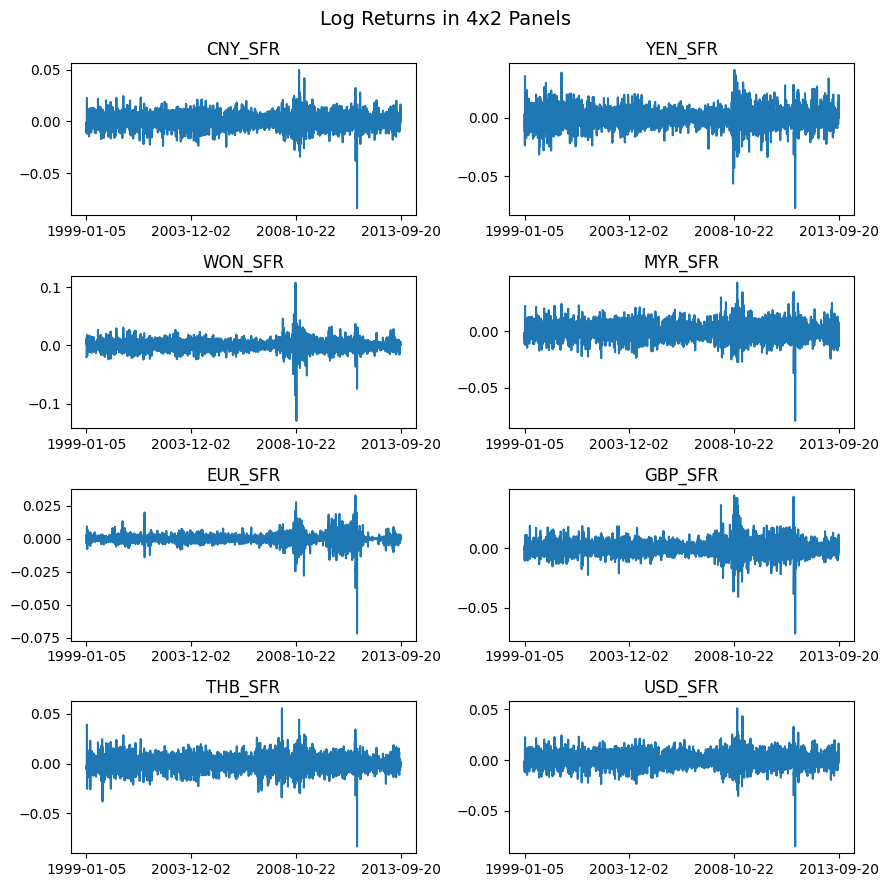

In [10]:
# Set the layout for 4x2 subplots
fig, axs = plt.subplots(4, 2, figsize=(9,9))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Select three dates for x-axis labels
selected_dates = fxrates1_logret.index[::(len(fxrates1_logret.index) // 3)]

# Loop through each column of the DataFrame and plot in the corresponding subplot
for j0, ax in zip(range(1, fxrates1_logret.shape[1] + 1), axs):
    column_name = fxrates1_logret.columns[j0 - 1]
    ax.plot(range(len(fxrates1_logret)),fxrates1_logret.iloc[:, j0 - 1])
    ax.set_xticks(range(0, len(fxrates1_logret), len(fxrates1_logret) // 3))
    ax.set_xticklabels(selected_dates)
    ax.set_title(column_name)

    
# Set the main title for the entire plot
plt.suptitle("Log Returns in 4x2 Panels", fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

<h3> Fit Regression Model Prior to July 2005 </h3>

First, we fit the regression model for the period prior to July 2005 when the
Chinese currency was pegged to the US dollar.

In [11]:
# Filter the data to the desired time period (2001-01-01 to 2005-06-30)
start_date = "2001-01-01"
end_date = "2005-06-30"
fxrates_period1 = fxrates1_logret.loc[start_date:end_date]

# Define the dependent and independent variables
y = fxrates_period1['CNY_SFR']
X = fxrates_period1[['USD_SFR', 'YEN_SFR', 'EUR_SFR', 'GBP_SFR']]

# Add a constant term to the independent variables (for intercept in the regression)
X = sm.add_constant(X)

# Fit the linear regression model
lmfit_period1 = sm.OLS(y, X).fit()

# Display the summary of the regression results
print(lmfit_period1.summary())

                            OLS Regression Results                            
Dep. Variable:                CNY_SFR   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.885e+06
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        00:02:51   Log-Likelihood:                 9015.6
No. Observations:                1131   AIC:                        -1.802e+04
Df Residuals:                    1126   BIC:                        -1.800e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.084e-07   2.49e-06     -0.044      0.9

The regression fit identifies the pegging of the Yuan (CNR SFR) to the US
Dollar (USD SFR). The R − Squared is nearly 1.0

<h3> Fit Regression Model For First Six Months After Announcement </h3>

Second, we fit the regression model for the first six months following the announcement of the change in currency policy.

In [12]:
# Filter the data to the desired time period (July 1, 2005, to December 31, 2005)
start_date = "2005-07-01"
end_date = "2005-12-31"
fxrates_period2 = fxrates1_logret.loc[start_date:end_date]

# Define the dependent and independent variables
y = fxrates_period2['CNY_SFR']
X = fxrates_period2[['USD_SFR', 'YEN_SFR', 'EUR_SFR', 'GBP_SFR', 'WON_SFR', 'MYR_SFR', 'THB_SFR']]

# Add a constant term to the independent variables (for intercept in the regression)
X = sm.add_constant(X)

# Fit the linear regression model
lmfit_period2 = sm.OLS(y, X).fit()

# Display the summary of the regression results
print(lmfit_period2.summary())

                            OLS Regression Results                            
Dep. Variable:                CNY_SFR   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     318.6
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           4.84e-73
Time:                        00:02:51   Log-Likelihood:                 639.23
No. Observations:                 125   AIC:                            -1262.
Df Residuals:                     117   BIC:                            -1240.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.881      0.3

During this six-month period, there is evidence of the Yuan departing from a US Dollar peg. The exchange rates with the statsitically significant regression parameters are for the Korean Won (WON SFR) and the Malaysian Ringgit
(MYR SFR).

<h3> Fit Regression Model For Each Annual Periods From 2006 Through 2013 </h3>

To examine for futher changes in the implicit reference basket, we fit the same model for the annual periods from 2006 through 2012 and for the first 6 months of 2013.

In [13]:
# Convert the DataFrame's index to a pandas DatetimeIndex
fxrates1_logret.index = pd.to_datetime(fxrates1_logret.index)

# Iterate over each year from 2006 to 2013
for year in range(2006, 2014):
    year_str = str(year)
    
    # Filter the data for the current year
    fxrates_year = fxrates1_logret.loc[fxrates1_logret.index.year == year]
    
    # Define the dependent and independent variables
    y = fxrates_year['CNY_SFR']
    X = fxrates_year[['USD_SFR', 'YEN_SFR', 'EUR_SFR', 'GBP_SFR', 'WON_SFR', 'MYR_SFR', 'THB_SFR']]

    # Add a constant term to the independent variables (for intercept in the regression)
    X = sm.add_constant(X)

    # Fit the linear regression model for the current year
    lmfit_year = sm.OLS(y, X).fit()

    # Display the summary of the regression results for the current year
    print("\n\n--------------------------------")
    print(year_str + ":")
    print(lmfit_year.summary())

    # Calculate the annualized appreciation rate to the implied reference basket (USD)
    rate_appreciation_usd = round(np.exp(252 * lmfit_year.params['const']) - 1, 3)

    print(f"\n{year_str}\tAnnualized appreciation rate to implied reference basket: {rate_appreciation_usd}%")



--------------------------------
2006:
                            OLS Regression Results                            
Dep. Variable:                CNY_SFR   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2559.
Date:                Tue, 16 Jan 2024   Prob (F-statistic):          1.16e-223
Time:                        00:02:51   Log-Likelihood:                 1489.2
No. Observations:                 251   AIC:                            -2962.
Df Residuals:                     243   BIC:                            -2934.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

**From these annual results we note:** </br>
• These fitted regression models demonstrate that the statistical evidence
for the underlying reference basket of currencies changes from year to year. </br>
• Note how the different exhange rates are significant predictors of the daily
change in the Yuan exchange rate for different years. </br>
• The computations include a measure of the annualized trend in the Yuan
exchange rate relative to the other currencies. Notice that this rate is
negative, to varying degrees over the seven-plus years.

<h3> 2012 Period Analysis </h3>

We illustrate some additional features of exchange rate regime modelling using the reference basket implied by the data for 2012.

In [14]:
# Filter the data for the year 2012
year = "2012"
fxrates_year = fxrates1_logret[fxrates1_logret.index.year == int(year)]

<h4> Plot Currency Returns For Yuan & All Basket Currencies </h4>

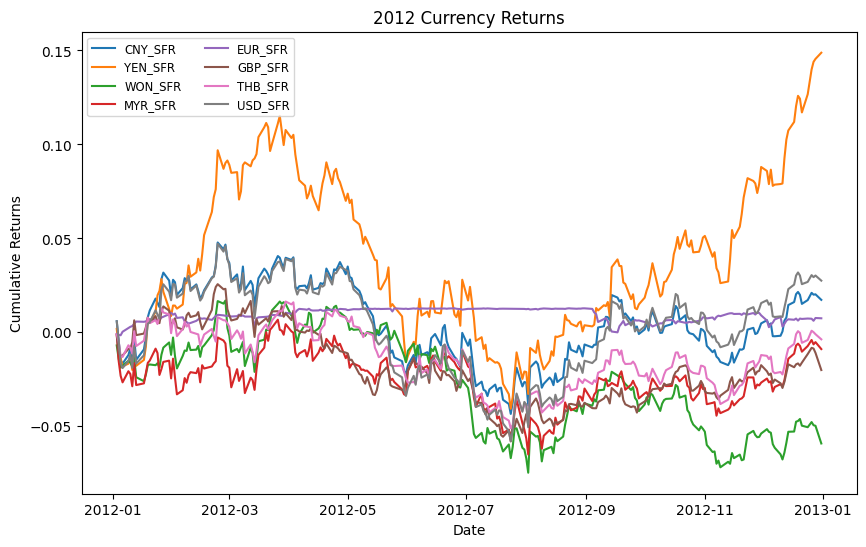

In [15]:
# Calculate the cumulative sum of log returns for each currency pair
cumulative_returns = fxrates_year.cumsum()

# Create the time series plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns)
plt.title("2012 Currency Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(fxrates_year.columns, loc='upper left', fontsize='small', ncol=2)
plt.show()

<h4> Regression Model </h4>

In [16]:
# Define the dependent variable (y) and independent variables (X) for the linear regression
y = fxrates_year['CNY_SFR']
X = fxrates_year[['USD_SFR', 'YEN_SFR', 'EUR_SFR', 'GBP_SFR', 'WON_SFR', 'MYR_SFR', 'THB_SFR']]

<h4> Correlation Coefficient For MultiCollinearity </h4>

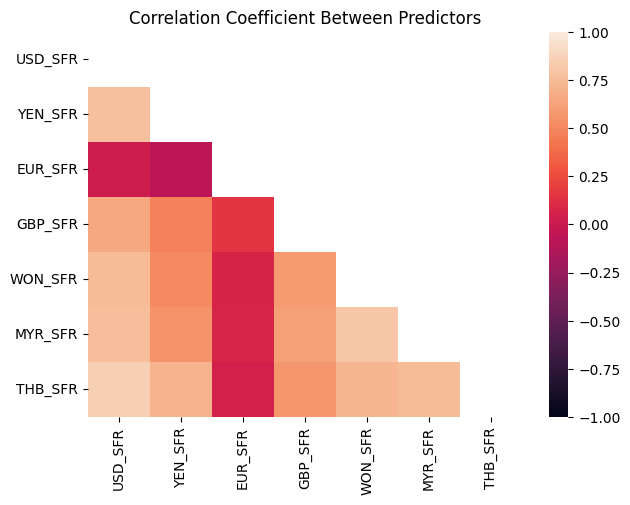

In [17]:
plt.figure(figsize=(7,5))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(X.corr(), dtype=bool))

# generate correlation coefficient heatmap
sns.heatmap(X.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Between Predictors')

plt.show()

Any feature pairs with correlation coefficient exceeding 0.75 or -0.75 (highly correlated) are suspected of causing multicollinearity. </br>
From the heatmap, we can identify strong relationships between: </br>
[YEN_SFR,USD_SFR] </br> 
[MYR_SFR,USD_SFR] </br> 
[THB_SFR,USD_SFR] </br>
[WON_SFR,MYR_SFR] </br>
[WON_SFR,USD_SFR] </br>

But, Do we eliminate all of these features to develop models with less overall variance? The answer is no.

Eliminating features runs the risk of removing much important information.

<h4> Variance Inflation Factor (VIF) For Multicollinearity</h4>

In [18]:
def compute_vif(considered_features):
    X = fxrates_year[considered_features]
    X['intercept'] = 1
    vif = pd.DataFrame()
    vif["Predictors"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Predictors']!='intercept']
    return vif

In [19]:
# Calculate VIF for each predictors
features = ['YEN_SFR', 'WON_SFR', 'MYR_SFR', 'EUR_SFR', 'GBP_SFR', 'THB_SFR', 'USD_SFR']
print(compute_vif(features).sort_values('VIF', ascending=False))

  Predictors       VIF
6    USD_SFR  6.041244
5    THB_SFR  4.156618
2    MYR_SFR  3.707557
1    WON_SFR  3.468195
0    YEN_SFR  2.637220
4    GBP_SFR  1.910000
3    EUR_SFR  1.060923


VIF for all predictors are less than 10 (which shows predictor have serious multicollinearity with at least one of other predictors). So, We can consider all the predictors for our model.

In [20]:
# Add a constant term to the independent variables (for intercept in the regression)
X = sm.add_constant(X)

# Fit the linear regression model using OLS
lmfit_year = sm.OLS(y, X).fit()

# Display the summary of the regression results
print(lmfit_year.summary())

                            OLS Regression Results                            
Dep. Variable:                CNY_SFR   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1165.
Date:                Tue, 16 Jan 2024   Prob (F-statistic):          5.28e-183
Time:                        00:02:51   Log-Likelihood:                 1392.8
No. Observations:                 251   AIC:                            -2770.
Df Residuals:                     243   BIC:                            -2741.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.958e-05   6.11e-05     -0.320      0.7

<h4> Plot Currency Returns For Yuan & Implied Reference Basket </h4>

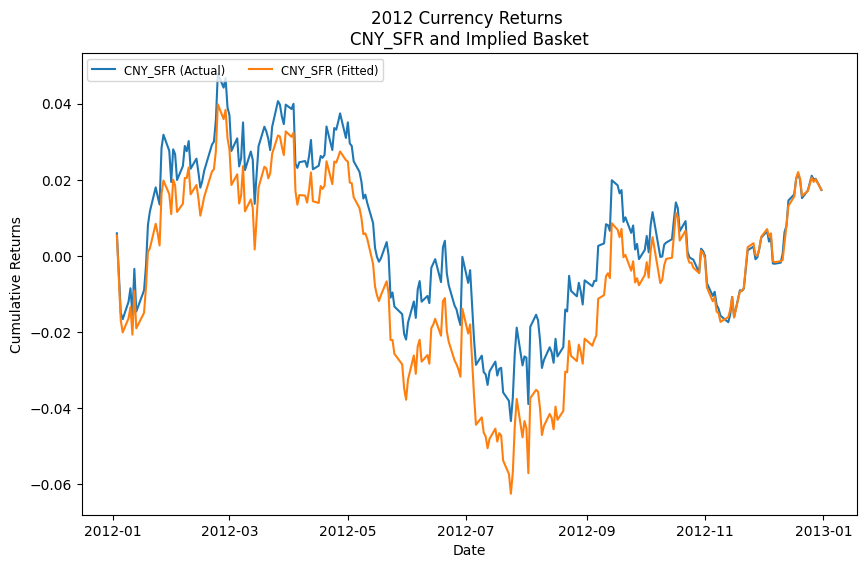

In [21]:
# Calculate the fitted log returns (y.fit) using the residuals from the linear regression
y_actual = fxrates_year['CNY_SFR']
y_fit = y_actual - lmfit_year.resid

# Calculate the cumulative sum of actual and fitted log returns
cumulative_returns = pd.concat([y_actual.cumsum(), y_fit.cumsum()], axis=1)

# Create the time series plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns)
plt.title("2012 Currency Returns \nCNY_SFR and Implied Basket")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(['CNY_SFR (Actual)', 'CNY_SFR (Fitted)'], loc='upper left', fontsize='small', ncol=2)
plt.show()

Note how closely the reference basket tracks the Yuan. This is to be expected given the high R−squared of the regression.

<h3> Regression Diagnostics For 2012 Period </h3>

<h4> Datapoints Summary </h4>

In [22]:
# Datapoints summary - leverages, standardized residuals, studentized residuals, , DFFITS, Cook's Distance
datapoints_summary = lmfit_year.get_influence().summary_frame()[["hat_diag", "standard_resid", "student_resid", "cooks_d", "dffits"]]
print(datapoints_summary)

            hat_diag  standard_resid  student_resid   cooks_d    dffits
Date                                                                   
2012-01-03  0.070824        0.630914       0.630131  0.003793  0.173969
2012-01-04  0.060956        0.508338       0.507561  0.002097  0.129316
2012-01-05  0.044015        0.929724       0.929464  0.004975  0.199438
2012-01-06  0.028988        1.640886       1.646654  0.010048  0.284513
2012-01-09  0.034361        0.920548       0.920258  0.003769  0.173594
...              ...             ...            ...       ...       ...
2012-12-24  0.027502        0.788179       0.787563  0.002196  0.132440
2012-12-26  0.024912        0.357939       0.357296  0.000409  0.057109
2012-12-27  0.012685        0.175525       0.175174  0.000049  0.019856
2012-12-28  0.021020       -0.565794      -0.565001  0.000859 -0.082789
2012-12-31  0.054199       -0.120999      -0.120753  0.000105 -0.028907

[251 rows x 5 columns]


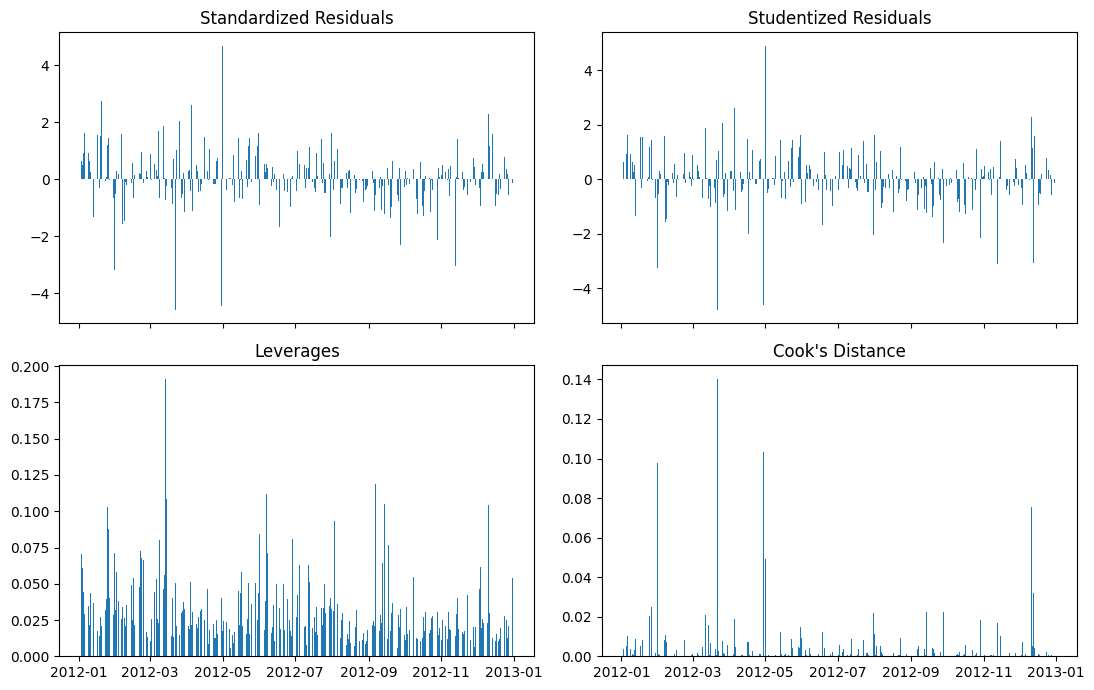

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7), sharex=True)

axes[0,0].bar(datapoints_summary.index, datapoints_summary['standard_resid'])
axes[0,0].set_title("Standardized Residuals")
axes[0,1].bar(datapoints_summary.index, datapoints_summary['student_resid'])
axes[0,1].set_title("Studentized Residuals")
axes[1,0].bar(datapoints_summary.index, datapoints_summary['hat_diag'])
axes[1,0].set_title("Leverages")
axes[1,1].bar(datapoints_summary.index, datapoints_summary['cooks_d'])
axes[1,1].set_title("Cook's Distance")

plt.tight_layout()
plt.show() 

<h4> Outliers Cases </h4>

In [24]:
studentized_thres = 2

outliers_df = datapoints_summary[(datapoints_summary['student_resid']>studentized_thres) | (datapoints_summary['student_resid']<-1*studentized_thres)]
outliers = outliers_df[["student_resid"]]
print("Outliers Cases:")
print(outliers)

Outliers Cases:
            student_resid
Date                     
2012-01-20       2.781241
2012-01-31      -3.261146
2012-03-22      -4.798225
2012-03-26       2.060551
2012-04-05       2.624900
2012-04-17      -2.011377
2012-04-30      -4.633377
2012-05-01       4.916105
2012-07-31      -2.051242
2012-09-28      -2.336146
2012-10-29      -2.168180
2012-11-13      -3.118019
2012-12-11       2.298523
2012-12-13      -3.080367


<h4> High Leverages Cases </h4>

In [25]:
leverage_thres = 0.1

high_leverages_df = datapoints_summary[(datapoints_summary['hat_diag']>leverage_thres)]
high_leverages = high_leverages_df[["hat_diag"]]
print("High Leverages Cases:")
print(high_leverages)

High Leverages Cases:
            hat_diag
Date                
2012-01-25  0.102743
2012-03-14  0.191016
2012-03-15  0.108513
2012-06-07  0.111719
2012-09-07  0.118493
2012-09-14  0.105309
2012-12-11  0.104340


<h4> Influential Cases </h4>

In [26]:
cooks_thres = 0.05

influential_df = datapoints_summary[(datapoints_summary['cooks_d']>cooks_thres)]
influential = influential_df[["cooks_d"]]
print("Influential Cases:")
print(influential)

Influential Cases:
             cooks_d
Date                
2012-01-31  0.097734
2012-03-22  0.140070
2012-04-30  0.103077
2012-12-11  0.075601


<h4> Plot Highlight Influential Cases </h4>

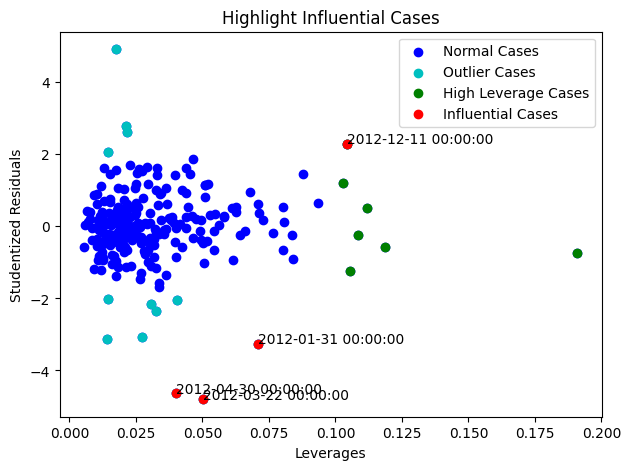

In [27]:
plt.figure(figsize=(7, 5))
plt.scatter(datapoints_summary['hat_diag'], datapoints_summary['student_resid'], color='b', label='Normal Cases')
plt.scatter(outliers_df['hat_diag'], outliers_df['student_resid'], color='c', label='Outlier Cases')
plt.scatter(high_leverages_df['hat_diag'], high_leverages_df['student_resid'], color='g', label='High Leverage Cases')
plt.scatter(influential_df['hat_diag'], influential_df['student_resid'], color='r', label='Influential Cases')
    
for index, row in influential_df.iterrows():
    plt.annotate(index, (row['hat_diag'], row['student_resid']))
    

plt.xlabel('Leverages')
plt.ylabel('Studentized Residuals')
plt.title('Highlight Influential Cases')

plt.legend()
plt.show()

<h3> Residual Diagnostics For 2012 Period </h3>

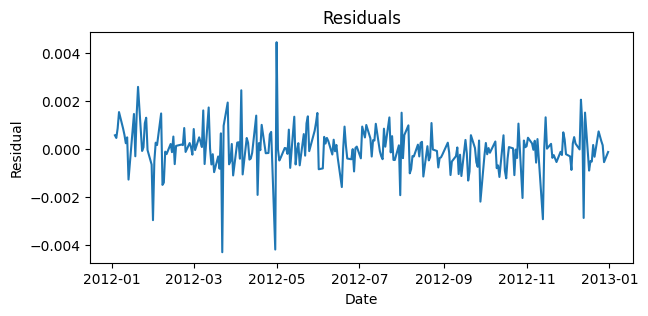

In [28]:
# Get the residuals from the fitted model
residuals = lmfit_year.resid

# Plot residuals against time
plt.figure(figsize=(7, 3))
plt.plot(residuals.index, residuals.values)
plt.xlabel("Date")
plt.ylabel("Residual")
plt.title("Residuals")
plt.show()

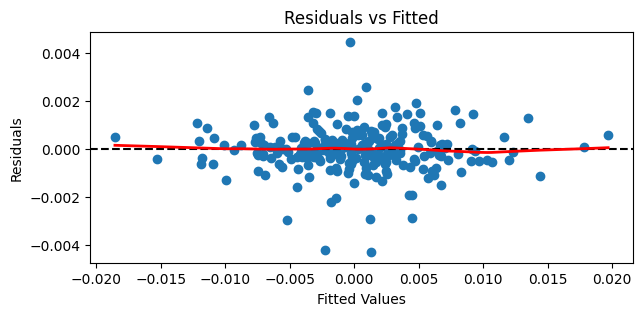

In [29]:
# Create the residuals vs. fitted plot
residuals = lmfit_year.resid
fitted_values = lmfit_year.fittedvalues

# Calculate the smoothed estimate using LOESS (locally weighted scatterplot smoothing)
lowess_smoothed = sm.nonparametric.lowess(residuals, fitted_values, frac=0.5)

plt.figure(figsize=(7,3))
plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='red', linewidth=2, label='Smoothed Estimate')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

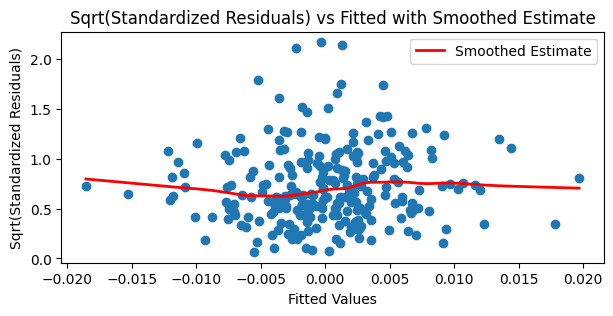

In [30]:
# Calculate the standardized residuals
standardized_residuals = lmfit_year.get_influence().resid_studentized_internal

# Take the square root of the absolute values of standardized residuals
sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))

# Get the fitted values from the fitted model
fitted_values = lmfit_year.fittedvalues

# Calculate the smoothed estimate using LOESS (locally weighted scatterplot smoothing)
lowess_smoothed = sm.nonparametric.lowess(sqrt_standardized_residuals, fitted_values, frac=0.5)

plt.figure(figsize=(7,3))
plt.scatter(fitted_values, sqrt_standardized_residuals)
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='red', linewidth=2, label='Smoothed Estimate')
plt.xlabel('Fitted Values')
plt.ylabel('Sqrt(Standardized Residuals)')
plt.title('Sqrt(Standardized Residuals) vs Fitted with Smoothed Estimate')
plt.legend()
plt.show()

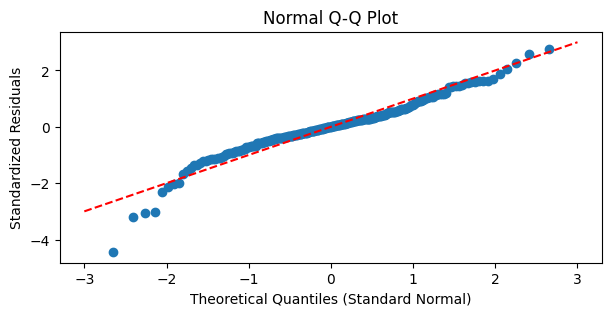

In [31]:
# Calculate the standardized residuals
standardized_residuals = lmfit_year.get_influence().resid_studentized_internal

# Sort the standardized residuals
sorted_standardized_residuals = sorted(standardized_residuals)

# Calculate theoretical quantiles for the standard normal distribution
theoretical_quantiles = np.linspace(0, 100, len(standardized_residuals))  
theoretical_quantiles_values = stats.norm.ppf(theoretical_quantiles / 100)

# Create the normal Q-Q plot of the standardized residuals
plt.figure(figsize=(7,3))
plt.scatter(theoretical_quantiles_values, sorted_standardized_residuals)
plt.plot([-3, 3], [-3, 3], color='red', linestyle='dashed')
plt.xlabel('Theoretical Quantiles (Standard Normal)')
plt.ylabel('Standardized Residuals')
plt.title('Normal Q-Q Plot')
plt.show()

These diagnostics indicate: </br>
• The residuals appear well-behaved as they relate to the size of the fitted
values. The residual variance does not increase with the magnitude of the
fitted values. </br>
• The residuals exhibit heavier tails than those of a normal distribution.
However for those residuals within two standard deviations of their mean,
their distribution is close to that of a normal distribution.